## Constrained multiobjective optimization using MOBO


In [1]:
# main function
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline


from xopt.bayesian.algorithms import mobo
from botorch.utils.multi_objective.pareto import is_non_dominated

import os
SMOKE_TEST = os.environ.get('SMOKE_TEST')

# test function
from xopt.evaluators import test_TNK

Signature:
mobo(
    vocs,
    evaluate_f,
    ref=None,
    n_steps=1,
    n_initial_samples=1,
    output_path=None,
    custom_model=None,
    executor=None,
    restart_file=None,
    initial_x=None,
    verbose=True,
    generator_options=None,
)
Docstring:
Multi-objective Bayesian optimization

Parameters
----------
vocs : dict
    Varabiles, objectives, constraints and statics dictionary,
    see xopt documentation for detials

evaluate_f : callable
    Returns dict of outputs after problem has been evaluated

ref : list
    Reference point for multi-objective optimization.

n_steps : int, default = 1
    Number of optimization steps to execute

n_initial_samples : int, defualt = 1
    Number of initial samples to take before using the model,
    overwritten by initial_x

output_path : str, default = ''
    Path location to place outputs

custom_model : callable, optional
    Function of the form f(train_inputs, train_outputs) that returns
    a trained custom model

executor : 

In [2]:
# Get VOCS
VOCS = test_TNK.VOCS

# add reference point
ref = [1.4, 1.4]

print(VOCS)
# Get evaluate function
EVALUATE = test_TNK.evaluate_TNK
n_steps = 30

gen_options = {'batch_size':4,                      ## Specify batched mobo
               'use_gpu':False,                     ## Use GPU
              }

if SMOKE_TEST:
    n_steps = 10
    gen_options['batch_size'] = 1
    gen_options['num_restarts'] = 2
    gen_options['raw_samples'] = 2


# Run the optimization
results = mobo(VOCS, EVALUATE,
               ref = ref,
               generator_options = gen_options,
               n_initial_samples=5,                   ## Specify number of initial random samples
               initial_x=None,                        ## Specify explicit initial sample locations (overwrites n_initial_samples)
               n_steps=n_steps,                       ## number of optimization step
               # restart_data_file = 'results.json',  ## restart optimization file
               # custom_model = myCustomModel,        ## Specify custom model creation function (see examples/bayes_exp/serial_nans.ipynb)
               verbose=True)

print(results.keys())

{'name': 'TNK_test', 'description': 'Constrainted test function TNK. See Table V in https://www.iitk.ac.in/kangal/Deb_NSGA-II.pdf', 'simulation': 'test_TNK', 'variables': {'x1': [0, 3.14159], 'x2': [0, 3.14159]}, 'objectives': {'y1': 'MINIMIZE', 'y2': 'MINIMIZE'}, 'constraints': {'c1': ['GREATER_THAN', 0], 'c2': ['LESS_THAN', 0.5]}, 'constants': {'a': 'dummy_constant'}}
started running optimization with generator: <xopt.bayesian.generators.mobo.MOBOGenerator object at 0x00000252F2B63DC0>
submitting initial candidates at time 2021-09-01T16:16:34-05:00
starting optimization loop
Model creation time: 0.2615 s
Candidate generation time: 0.09104 s
Candidate(s): tensor([[0.2783, 0.4224]], dtype=torch.float64)
submitting candidates at time 2021-09-01T16:16:34-05:00
Model creation time: 0.287 s
Candidate generation time: 0.047 s
Candidate(s): tensor([[3.1416, 0.0000]], dtype=torch.float64)
submitting candidates at time 2021-09-01T16:16:35-05:00
Model creation time: 0.3764 s
Candidate generatio

dict_keys(['variables', 'objectives', 'corrected_objectives', 'constraints', 'corrected_constraints', 'constraint_status', 'feasibility', 'model'])


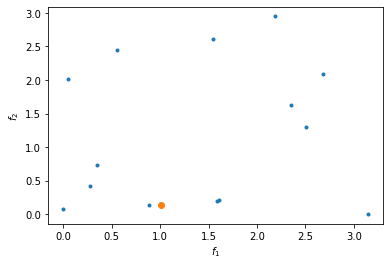

In [3]:
fig, ax = plt.subplots()
print(results.keys())
train_y = results['objectives']
valid_y = train_y[results['feasibility'].flatten()]
ax.plot(train_y[:, 0], train_y[:, 1], '.')
ax.set_ylabel('$f_2$')
ax.set_xlabel('$f_1$')

# highlight Pareto front, ONLY using valid observations (note botorch assumes maximization when determing dominant points)
non_dom = is_non_dominated(-valid_y)
ax.plot(valid_y[:,0][non_dom],valid_y[:,1][non_dom],'C1o')